In [1]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.ccf_utils import ccf_pts_convert_to_mm
from utils.combine_tools import apply_qc
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import r2_score
import warnings
from scipy.stats import gaussian_kde
warnings.filterwarnings('ignore')
from matplotlib import colors as mcolors
from matplotlib import cm
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
from scipy.stats import zscore
from scipy.stats import ttest_ind
from sklearn.cross_decomposition import CCA
from trimesh import load_mesh
from scipy.stats import pearsonr
from aind_ephys_utils import align
%matplotlib inline

In [2]:
criteria_name = 'basic_ephys'

In [3]:
# load constraints and data
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
    
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
beh_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', criteria_name)
if not os.path.exists(beh_folder):
    os.makedirs(beh_folder)
# start with a mask of all True
mask = pd.Series(True, index=combined_tagged_units.index)

In [23]:
constraints['isi_violations'] = {'bounds': [0.0, 0.12]}

Applying bounds for isi_violations: [0.0, 0.12]
 - isi_violations: 17849 -> 8469 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8469 -> 6045 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 6045 -> 6020 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto units after filtering: 404
Number of non-opto units after filtering: 6020


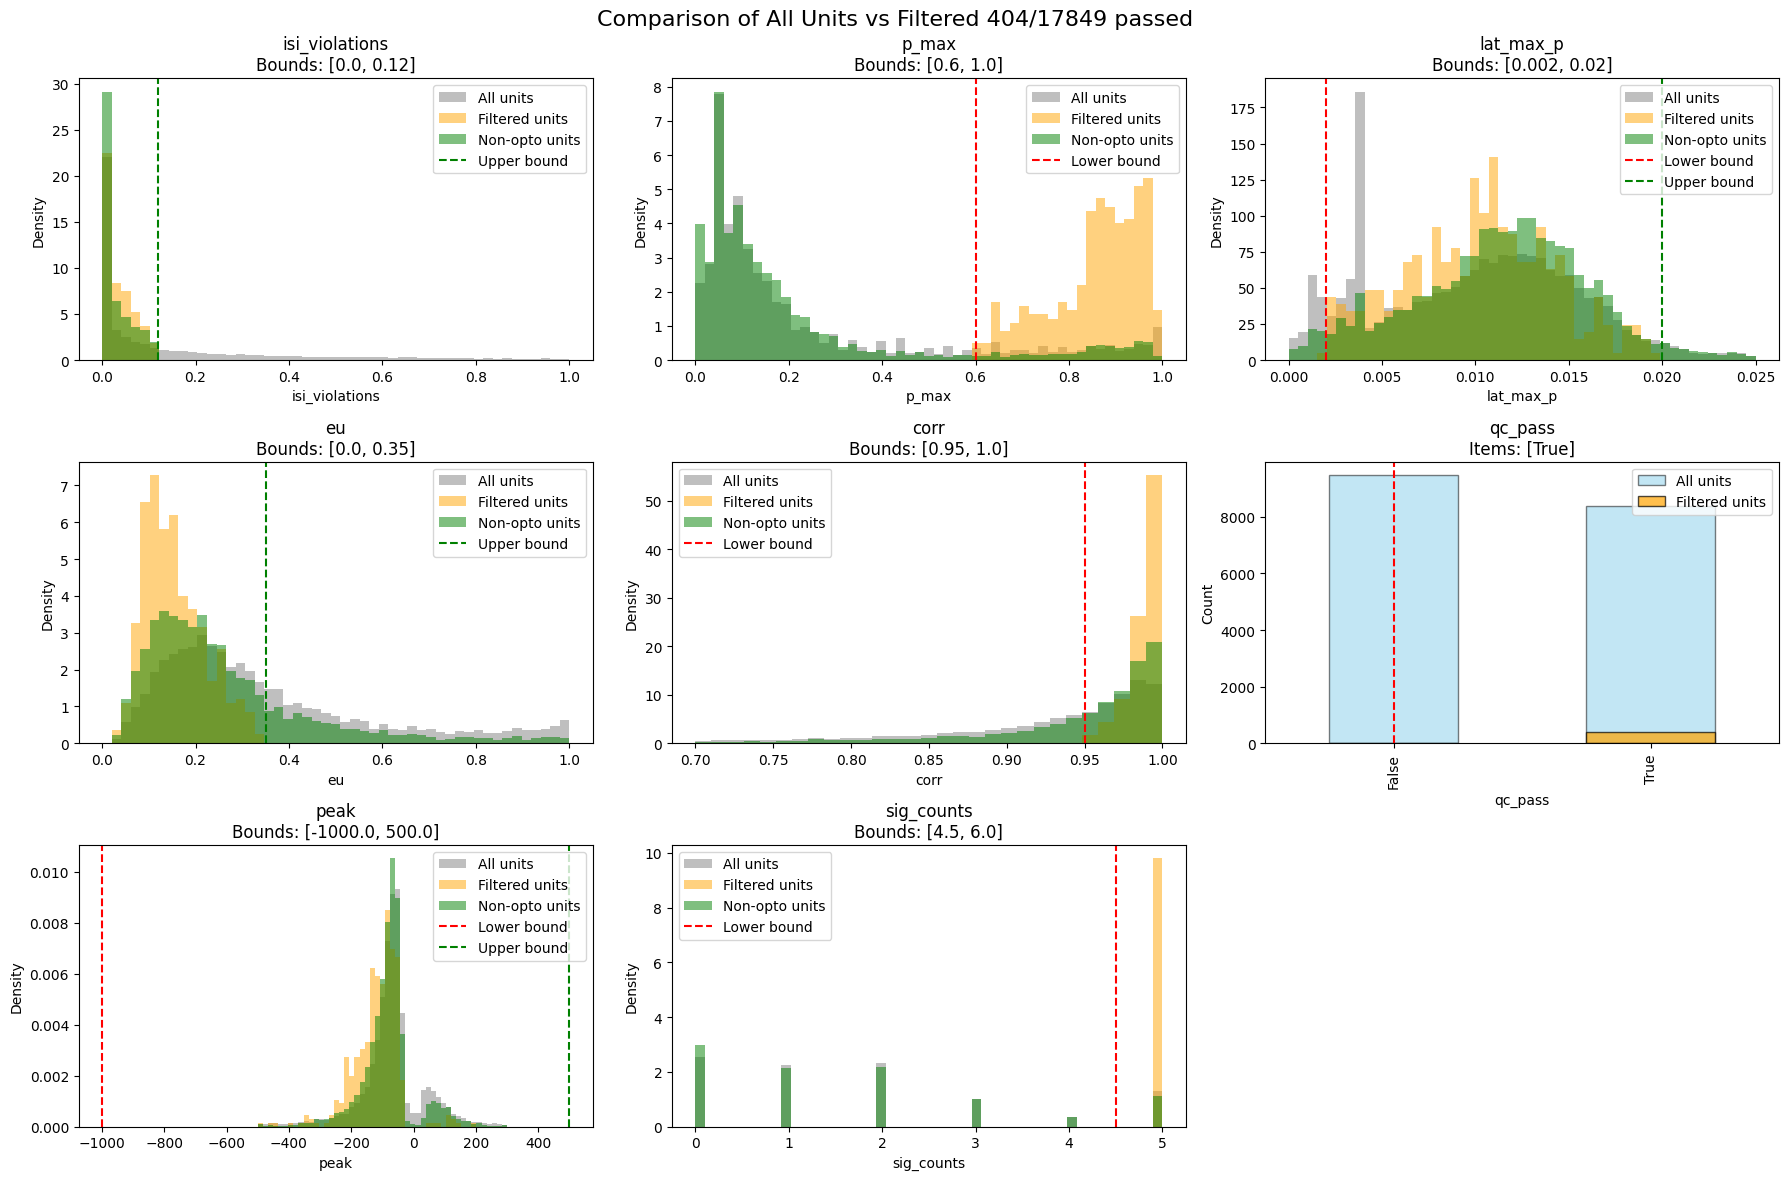

In [24]:
combined_tagged_units_filtered, combined_tagged_units, fig = apply_qc(combined_tagged_units, constraints)

## Anti-dromic cells

In [28]:
combined_tagged_units_filtered[color_code_filtered]

,session,unit,qc_pass,opto_tagged,opto_tagging_pre,opto_tagging_post,anti,in_df,trial_count,p_max,...,x_ccf,y_ccf,z_ccf,anti_resp,proj,selected_qc_only,count_max,selected_opto_only,selected,selected_no_opto
22,ecephys_713854_2024-03-08_15-43-01,3,True,True,True,True,True,False,0,0.610496,...,NaN,NaN,NaN,1,PrL,True,5.0,True,True,True
24,ecephys_713854_2024-03-08_15-43-01,20,True,True,True,True,True,False,0,0.845806,...,NaN,NaN,NaN,2,PrL,True,5.0,True,True,True
102,behavior_716325_2024-05-31_10-31-14,379.0,True,True,False,True,True,True,541,0.928548,...,NaN,NaN,NaN,3,S1,True,5.0,True,True,True
107,behavior_751004_2024-12-20_13-26-11,263,True,True,True,True,False,True,517,0.736687,...,NaN,NaN,NaN,1,S1,True,5.0,True,True,True
117,behavior_751769_2025-01-17_11-37-39,288,True,True,True,True,True,True,351,0.885478,...,NaN,NaN,NaN,1,S1,True,5.0,True,True,True
119,behavior_751769_2025-01-18_10-15-25,20,True,True,True,True,True,True,349,0.772360,...,NaN,NaN,NaN,2,S1,True,5.0,True,True,True
121,behavior_751769_2025-01-18_10-15-25,29,True,True,True,True,True,True,349,0.898192,...,NaN,NaN,NaN,1,S1,True,5.0,True,True,True
145,behavior_751766_2025-02-13_11-31-21,24,True,True,True,True,True,True,465,0.768855,...,-6.746053,10.656173,-4.450846,2,S1,True,5.0,True,True,True
148,behavior_751766_2025-02-14_11-37-11,36,True,True,True,True,True,True,569,0.901270,...,-6.752373,10.619269,-4.555070,3,S1,True,5.0,True,True,True
153,behavior_751766_2025-02-14_11-37-11,249,True,True,True,True,True,True,569,0.808344,...,-6.751764,10.614647,-4.634432,3,S1,True,5.0,True,True,True


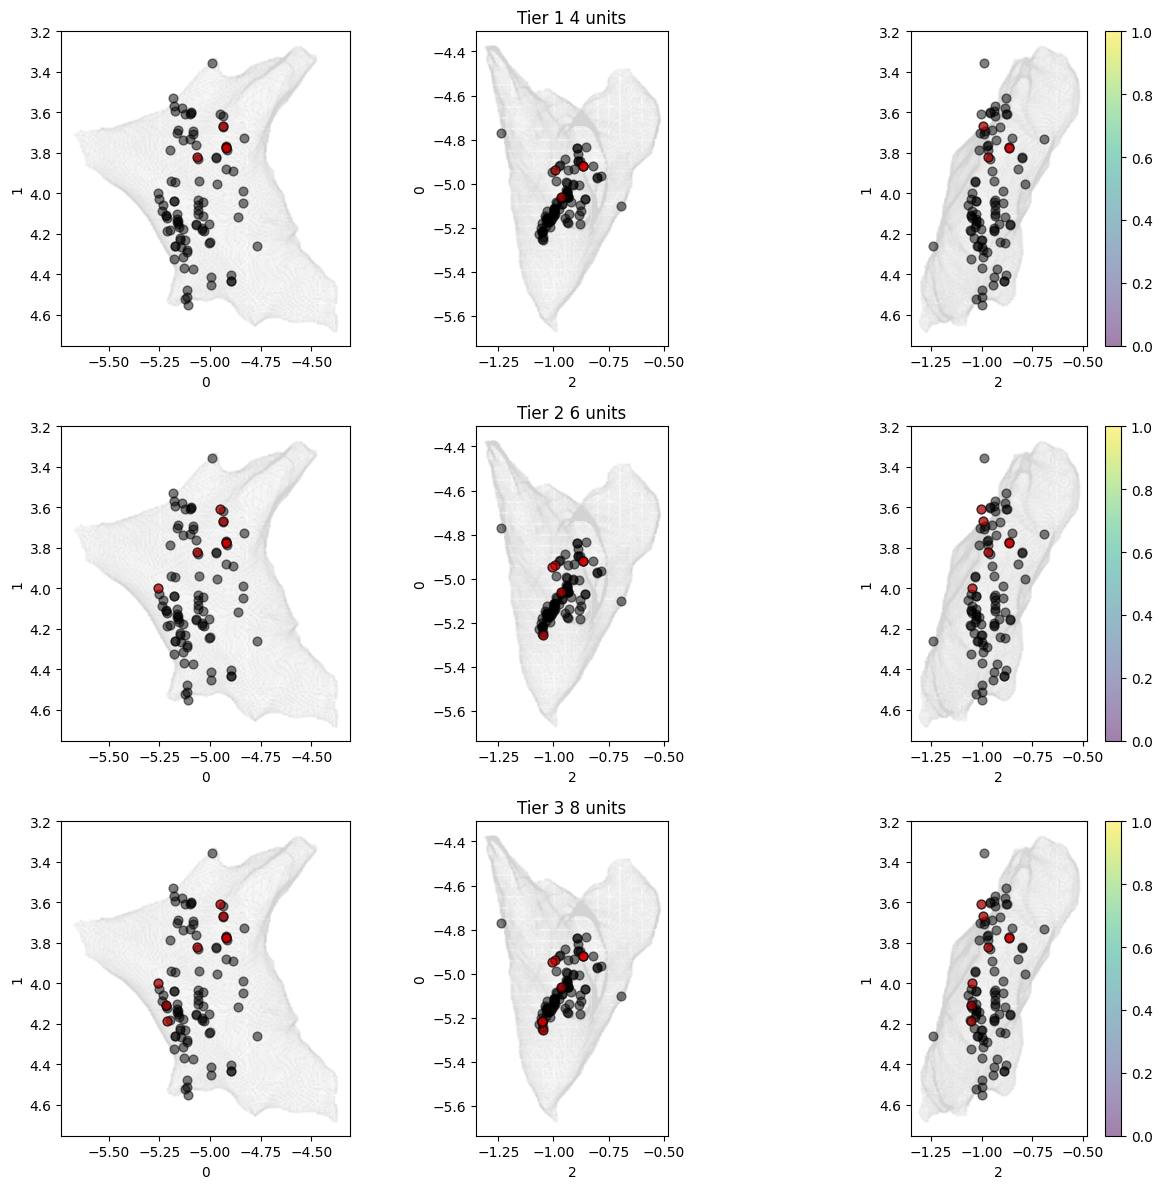

In [48]:
from matplotlib.colors import Normalize
norm = Normalize(vmin=0, vmax=1)

mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices_mm = ccf_pts_convert_to_mm(mesh_vertices)
mesh_vertices_mm[:, 2] = -np.abs(mesh_vertices_mm[:, 2])  # Mirror ML to left
blue_white_red = LinearSegmentedColormap.from_list(
    'blue_white_red',
    [(0, 'blue'), (0.5, 'white'), (1.0, 'red')]
)
ml, ap, dv = 2, 0, 1
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

x_ccf = -combined_tagged_units_filtered['x_ccf'].values / 25 * 1000
y_ccf = combined_tagged_units_filtered['y_ccf'].values / 25 * 1000
z_ccf = -combined_tagged_units_filtered['z_ccf'].values / 25 * 1000
ccfs = np.column_stack((y_ccf, z_ccf, x_ccf))
ccfs = ccf_pts_convert_to_mm(ccfs)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
filter = ~combined_tagged_units_filtered['session'].str.contains('ZS')

for ind, tier in enumerate(range(1, 4)):
    ax = axes[ind]
    color_code_filtered = (combined_tagged_units_filtered['anti_resp'].values<= tier) & (combined_tagged_units_filtered['anti_resp'].values>0)
    
    # ccfs = np.column_stack((x_ccf, y_ccf, z_ccf))
    # ccfs = ccf_pts_convert_to_mm(ccfs)
    ccfs[:, 2] = -np.abs(ccfs[:, 2])  # Mirror ML to left
    for plane, ax in zip(planes.keys(), axes[ind, :]):
        # Plot the mesh
        ax.scatter(mesh_vertices_mm[:, planes[plane][0]], mesh_vertices_mm[:, planes[plane][1]], color='lightgray', alpha=0.1, s = 0.2)
        # Plot the points
        sc = ax.scatter(ccfs[filter, planes[plane][0]], ccfs[filter, planes[plane][1]], c = 'k', s=40, edgecolor='k', alpha=0.5)
        sc = ax.scatter(ccfs[filter&color_code_filtered, planes[plane][0]], ccfs[filter&color_code_filtered, planes[plane][1]], c = 'r', s=40, edgecolor='k', alpha=0.5)
        if plane == 'hor':
            ax.set_title(f'Tier {tier} {np.sum(color_code_filtered[filter] & (~np.isnan(ccfs[filter, 0])))} units')
        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        # set equal aspect ratio
        ax.set_aspect('equal')
        if planes[plane][1] == dv:
            ax.invert_yaxis()
        # if plane == 'cor':
        #     fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)

    plt.tight_layout()

fig.savefig(fname=os.path.join(beh_folder, f'anti_resp_tiers_ccf_{criteria_name}.pdf'))
fig.savefig(fname=os.path.join(beh_folder, f'anti_resp_tiers_ccf_{criteria_name}.svg'))


In [51]:
np.sum((combined_tagged_units_filtered['anti_resp'][filter]==1) & (~np.isnan(ccfs[filter, 0])))

np.int64(4)

In [46]:
combined_tagged_units_filtered[combined_tagged_units_filtered['anti_resp']==1]

,session,unit,qc_pass,opto_tagged,opto_tagging_pre,opto_tagging_post,anti,in_df,trial_count,p_max,...,x_ccf,y_ccf,z_ccf,anti_resp,proj,selected_qc_only,count_max,selected_opto_only,selected,selected_no_opto
22,ecephys_713854_2024-03-08_15-43-01,3,True,True,True,True,True,False,0,0.610496,...,NaN,NaN,NaN,1,PrL,True,5.0,True,True,True
107,behavior_751004_2024-12-20_13-26-11,263,True,True,True,True,False,True,517,0.736687,...,NaN,NaN,NaN,1,S1,True,5.0,True,True,True
117,behavior_751769_2025-01-17_11-37-39,288,True,True,True,True,True,True,351,0.885478,...,NaN,NaN,NaN,1,S1,True,5.0,True,True,True
121,behavior_751769_2025-01-18_10-15-25,29,True,True,True,True,True,True,349,0.898192,...,NaN,NaN,NaN,1,S1,True,5.0,True,True,True
157,behavior_751181_2025-02-26_11-51-19,46,True,True,True,True,True,True,266,0.832780,...,-4.836011,10.321021,-4.223837,1,S1,True,5.0,True,True,True
161,behavior_751181_2025-02-26_11-51-19,273,True,True,True,True,True,True,266,0.862415,...,-4.833934,10.321246,-4.226056,1,S1,True,5.0,True,True,True
165,behavior_751181_2025-02-27_11-24-47,46,True,True,True,True,True,True,234,0.927157,...,-6.691911,10.337541,-4.117336,1,S1,True,5.0,True,True,True
174,behavior_754897_2025-03-13_11-20-42,49,True,True,True,True,True,True,564,0.933586,...,-4.732098,10.462646,-4.269973,1,S1,True,5.0,True,True,True
194,behavior_752014_2025-03-26_11-18-57,46,True,True,True,True,True,True,409,0.901733,...,NaN,NaN,NaN,1,S1,True,5.0,True,True,True
195,behavior_752014_2025-03-28_11-04-59,27,True,True,True,True,True,True,364,0.877238,...,NaN,NaN,NaN,1,S1,True,5.0,True,True,True


In [54]:
ccfs[filter_mask & (combined_tagged_units_filtered['anti_resp']==1)]

array([[        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [-4.9210215 ,  3.77383689, -0.86398865],
       [-4.92124615,  3.77605562, -0.86606617],
       [-4.93754063,  3.66733627, -0.99191074],
       [-5.06264582,  3.8199733 , -0.96790225],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan]])

In [56]:
import os
import numpy as np
import k3d
from matplotlib.colors import Normalize, LinearSegmentedColormap
from trimesh import load_mesh

# normalize colors
norm = Normalize(vmin=0, vmax=1)

# load and convert mesh
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices_mm = ccf_pts_convert_to_mm(mesh_vertices)
mesh_vertices_mm[:, 2] = -np.abs(mesh_vertices_mm[:, 2])  # Mirror ML to left

# mesh faces
mesh_indices = np.array(mesh.faces, dtype=np.uint32)

# unit coordinates in mm
x_ccf = -combined_tagged_units_filtered['x_ccf'].values / 25 * 1000
y_ccf = combined_tagged_units_filtered['y_ccf'].values / 25 * 1000
z_ccf = -combined_tagged_units_filtered['z_ccf'].values / 25 * 1000
ccfs = np.column_stack((y_ccf, z_ccf, x_ccf))
ccfs = ccf_pts_convert_to_mm(ccfs)
ccfs[:, 2] = -np.abs(ccfs[:, 2])  # Mirror ML to left

# filter units
filter_mask = ~combined_tagged_units_filtered['session'].str.contains('ZS')

# color coding by tier
tiers = combined_tagged_units_filtered['anti_resp'].values
tier_colors = norm(tiers)   # normalized values between 0 and 1
colormap = LinearSegmentedColormap.from_list('blue_white_red', [(0, 'blue'), (0.5, 'white'), (1.0, 'red')])
rgba = colormap(tier_colors)
rgb = (rgba[:, :3] * 255).astype(np.uint8)  # convert to 0–255 RGB

# build the plot
plot = k3d.plot()

# add mesh
plt_mesh = k3d.mesh(
    vertices=mesh_vertices_mm.astype(np.float32),
    indices=mesh_indices.astype(np.uint32),
    color=0x000000,
    opacity=0.15,
    side='double'
)
plot += plt_mesh

# add units
plt_points_all = k3d.points(
    positions=ccfs[filter_mask].astype(np.float32),
    color=0x000000,
    point_size=0.05,
    alpha=0.6
)
plot += plt_points_all

plt_points = k3d.points(
    positions=ccfs[filter_mask & (combined_tagged_units_filtered['anti_resp']==1)].astype(np.float32),
    color=0xFF0000,
    point_size=0.05,
    alpha=0.6
)
plot += plt_points

plt_points = k3d.points(
    positions=ccfs[filter_mask & (combined_tagged_units_filtered['anti_resp']==2)].astype(np.float32),
    color=0x0000FF,
    point_size=0.05,
    alpha=0.6
)
plot += plt_points

plt_points = k3d.points(
    positions=ccfs[filter_mask & (combined_tagged_units_filtered['anti_resp']==3)].astype(np.float32),
    color=0x00FF00,
    point_size=0.05,
    alpha=0.6
)
plot += plt_points

# save as html
html_file = os.path.join(beh_folder, f'anti_resp_tiers_ccf_{criteria_name}.html')
with open(html_file, 'w') as f:
    f.write(plot.get_snapshot())

plot.display()


Output()

In [39]:
ccfs

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       ...,
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

In [30]:
pip install k3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 122.1 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [k3d]3/4 [k3d]
Note: you may need to restart the kernel to use updated packages.
